**Fuel Oil & Distillate Market Intelligence Report**

Macro Regimes, Physical Balances & Trade-Flow Signals

**Objective**

This notebook builds a **market intelligence workflow for fuel oil and distillate markets**, designed to support **trading, risk management, and strategic decision-making.**

The analysis aims to answer three core questions:

*   **What price regime are we in?** (macro context)
*   **How tight is the physical market right now?** (balances & inventories)
*   **What are the key risks and trade implications?** (signals & scenarios)

**Markets Covered**
*   Crude oil (macro price regime context)
*   Residual fuel oil (fuel oil proxy)
*   Distillate (diesel/gasoil proxy with strong linkage to fuel oil)

**Data Used**

*   **World Bank Pink Sheet – annual commodity prices**

*   **U.S. EIA (Energy Information Administration)** – weekly petroleum fundamentals

**1. Configuration & Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

# ---- Parameters ----
ROLL_VOL_YEARS = 10
SHOCK_YEARS = [2008, 2014, 2020, 2022]

# ---- Optional: Google Drive mount (only if you load the XLSX from Drive) ----
from google.colab import drive
drive.mount('/content/drive')

# ---- EIA API key from Colab Secrets ----
from google.colab import userdata
EIA_API_KEY = userdata.get("EIA_API_KEY")
if not EIA_API_KEY:
    raise ValueError("EIA_API_KEY not found in Colab Secrets")

Mounted at /content/drive


2 Data Ingestion

2.1 World Bank Pink Sheet – Annual Prices (Nominal) bold text

## 2.1 World Bank Pink Sheet (Annual Prices)

We load and clean the World Bank Pink Sheet annual nominal prices. Key steps:
- Read the correct sheet
- Use the correct header row
- Standardize the year column and set it as index
- Convert numeric values safely

In [2]:
file_path = "/content/drive/MyDrive/lpg/CMO-Historical-Data-Annual.xlsx"

In [6]:
WB_FILE = "/content/drive/MyDrive/lpg/CMO-Historical-Data-Annual.xlsx"  # update if needed
WB_SHEET = "Annual Prices (Nominal)"
WB_HEADER_ROW = 8

def load_worldbank_annual(filepath: str, sheet_name: str, header_row: int) -> pd.DataFrame:
    df = pd.read_excel(filepath, sheet_name=sheet_name, header=header_row)
    # Your notebook: rename first col to Year
    df.columns.values[0] = "Year"
    # Clean Year
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["Year"]).copy()
    df["Year"] = df["Year"].astype(int)
    df = df.set_index("Year")
    # Convert numeric columns (handles commas/ellipsis)
    for col in df.columns:
        df[col] = pd.to_numeric(
            df[col].astype(str).str.replace(",", "").replace({"…": np.nan, "..": np.nan}),
            errors="coerce"
        )
    return df

wb = load_worldbank_annual(WB_FILE, WB_SHEET, WB_HEADER_ROW)
wb.head()

,CRUDE_PETRO,CRUDE_BRENT,CRUDE_DUBAI,CRUDE_WTI,COAL_AUS,COAL_SAFRICA,NGAS_US,NGAS_EUR,NGAS_JP,iNATGAS,...,ALUMINUM,IRON_ORE,COPPER,LEAD,Tin,NICKEL,Zinc,GOLD,PLATINUM,SILVER
Year,,,,,,,,,,,,,,,,,,,,,
1960,1.63,1.63,1.63,NaN,NaN,NaN,0.14,0.404774,NaN,NaN,...,511.471832,11.42,678.755833,198.850000,2196.733333,1631.000000,246.191667,35.27,83.500000,0.913700
1961,1.57,1.57,1.57,NaN,NaN,NaN,0.15,0.404774,NaN,NaN,...,511.471832,11.02,633.084167,176.975000,2449.891667,1711.000000,214.308333,35.25,83.500000,0.924442
1962,1.52,1.52,1.52,NaN,NaN,NaN,0.16,0.404774,NaN,NaN,...,498.060392,11.01,645.143333,155.283333,2471.383333,1761.000000,185.925000,35.23,83.500000,1.083725
1963,1.50,1.50,1.50,NaN,NaN,NaN,0.16,0.391351,NaN,NaN,...,498.795265,11.02,645.950833,174.808333,2507.733333,1741.666667,211.508333,35.09,80.930833,1.279108
1964,1.45,1.45,1.45,NaN,NaN,NaN,0.15,0.384150,NaN,NaN,...,525.985631,10.24,969.753333,277.883333,3412.741667,1741.666667,326.491667,35.10,88.480833,1.293000


In [7]:
pd.DataFrame({
    "rows": [wb.shape[0]],
    "cols": [wb.shape[1]],
    "year_min": [wb.index.min()],
    "year_max": [wb.index.max()],
    "missing_cells": [int(wb.isna().sum().sum())]
})

,rows,cols,year_min,year_max,missing_cells
0,65,69,1960,2024,452


2.2 EIA Weekly Fundamentals

## 2.2 EIA Weekly Fundamentals

We pull weekly EIA series used for:
- Crude context (stocks, utilization)
- Fuel oil / distillate balance (residual fuel oil stocks, distillate stocks, trade flows)

We keep the series IDs in a single map for transparency and reproducibility.

In [8]:
EIA_BASE = "https://api.eia.gov/v2"

def fetch_eia_series(series_id: str, api_key: str) -> pd.DataFrame:
    url = f"{EIA_BASE}/seriesid/{series_id}"
    r = requests.get(url, params={"api_key": api_key}, timeout=30)
    r.raise_for_status()
    return pd.DataFrame(r.json()["response"]["data"])

def fetch_many(series_map: dict, api_key: str):
    dfs, errors = [], []
    for name, sid in series_map.items():
        try:
            d = fetch_eia_series(sid, api_key)
            d["metric"] = name
            dfs.append(d)
            print("OK:", name)
        except Exception as e:
            errors.append((name, sid, str(e)))
            print("ERR:", name, e)
    out = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    if not out.empty:
        out["period"] = pd.to_datetime(out["period"])
        out["value"] = pd.to_numeric(out["value"], errors="coerce")
    return out, errors

In [9]:
SERIES_MAP = {
    # Crude context (optional but useful)
    "crude_oil_stocks_ex_spr": "PET.WCESTUS1.W",
    "refinery_utilization": "PET.WPULEUS3.W",

    # Fuel oil / distillate
    "residual_fuel_oil_stocks": "PET.WRESTUS1.W",
    "distillate_stocks": "PET.WDISTUS1.W",
    "distillate_imports": "PET.WDIIMUS2.W",
    "distillate_exports": "PET.WDIEXUS2.W",
    "distillate_product_supplied": "PET.WDIUPUS2.W",
}

series_table = pd.DataFrame([
    {"metric": k, "series_id": v} for k, v in SERIES_MAP.items()
])
series_table

,metric,series_id
0,crude_oil_stocks_ex_spr,PET.WCESTUS1.W
1,refinery_utilization,PET.WPULEUS3.W
2,residual_fuel_oil_stocks,PET.WRESTUS1.W
3,distillate_stocks,PET.WDISTUS1.W
4,distillate_imports,PET.WDIIMUS2.W
5,distillate_exports,PET.WDIEXUS2.W
6,distillate_product_supplied,PET.WDIUPUS2.W


In [10]:
eia_raw, eia_errors = fetch_many(SERIES_MAP, EIA_API_KEY)
eia_errors

OK: crude_oil_stocks_ex_spr
OK: refinery_utilization
OK: residual_fuel_oil_stocks
OK: distillate_stocks
OK: distillate_imports
OK: distillate_exports
OK: distillate_product_supplied


[]

3 Macro Price Regime Analysis (World Bank)

3.1 Annual crude price trend (Markdown cell)

## 3. Macro Price Regime Analysis (World Bank)

We first establish macro context using annual crude prices:
- Long-run trend
- Volatility regimes
- Key shock years

This provides context for interpreting weekly fundamentals.

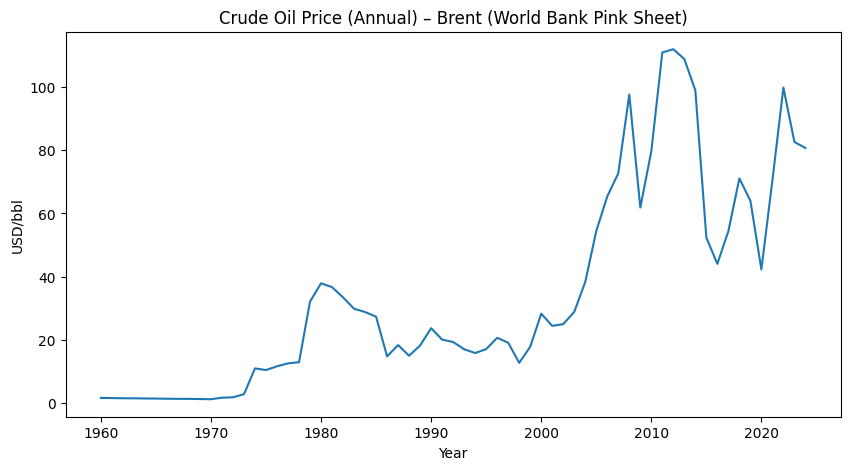

In [11]:
# Select Brent (same as your notebook) if available
if "CRUDE_BRENT" in wb.columns:
    crude = wb["CRUDE_BRENT"].dropna()
    crude_name = "Brent"
else:
    crude = wb.iloc[:, 0].dropna()
    crude_name = wb.columns[0]

plt.figure(figsize=(10,5))
plt.plot(crude.index, crude.values)
plt.xlabel("Year")
plt.ylabel("USD/bbl")
plt.title(f"Crude Oil Price (Annual) – {crude_name} (World Bank Pink Sheet)")
plt.show()

3.2 Rolling volatility (Markdown cell)

### Rolling Volatility (10-year)

Rolling volatility of annual returns approximates regime risk. Rising volatility usually indicates markets are more sensitive to shocks and balance surprises.


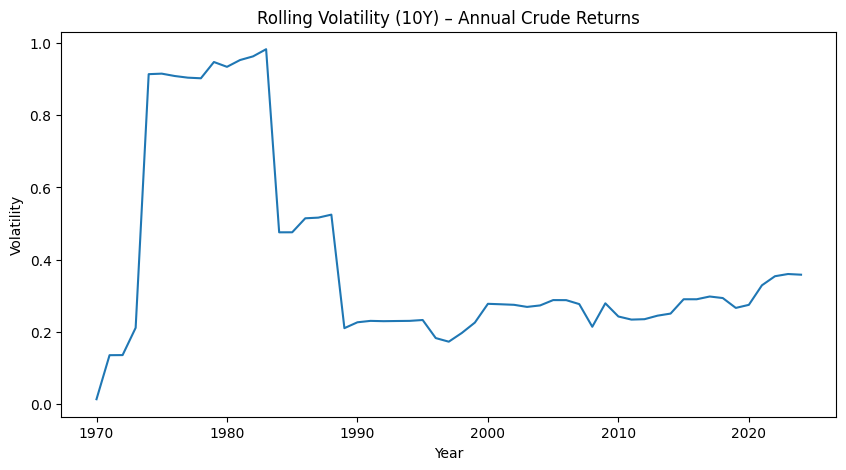

In [12]:
returns = crude.pct_change()
vol10 = returns.rolling(window=ROLL_VOL_YEARS).std()

plt.figure(figsize=(10,5))
plt.plot(vol10.index, vol10.values)
plt.xlabel("Year")
plt.ylabel("Volatility")
plt.title(f"Rolling Volatility ({ROLL_VOL_YEARS}Y) – Annual Crude Returns")
plt.show()

3.3 Shock-year overlay

We overlay major shock periods to highlight non-linear repricing episodes that dominate commodity risk.

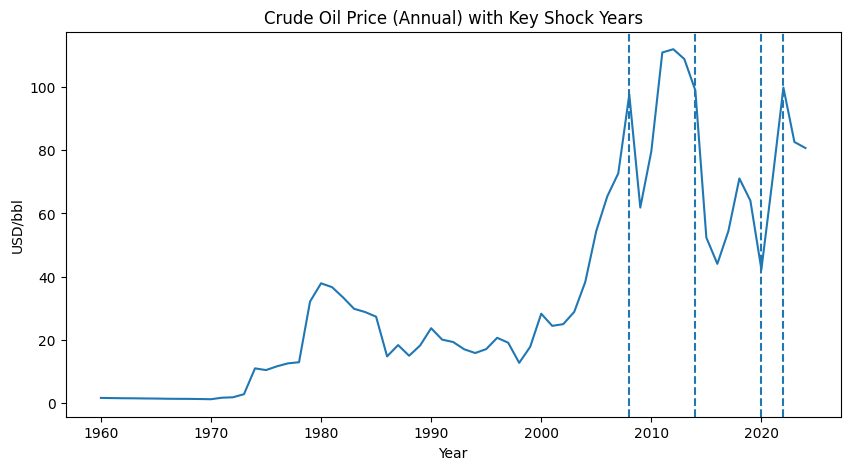

In [13]:
plt.figure(figsize=(10,5))
plt.plot(crude.index, crude.values)
plt.xlabel("Year")
plt.ylabel("USD/bbl")
plt.title("Crude Oil Price (Annual) with Key Shock Years")

for y in SHOCK_YEARS:
    if y in crude.index:
        plt.axvline(x=y, linestyle="--")

plt.show()

4) Fuel Oil & Distillate Fundamentals Dashboard (EIA)

## 4. Fuel Oil & Distillate Fundamentals Dashboard (EIA)

We build a weekly balance dashboard focusing on:
- Residual fuel oil stocks (fuel oil proxy)
- Distillate stocks
- Distillate net exports (arb / flow pressure proxy)
- Refinery utilization (supply-side driver)

These indicators are used to infer tightness, flow-driven dislocations, and risk conditions.

In [14]:
fuel_balance = (
    eia_raw
    .pivot_table(index="period", columns="metric", values="value")
    .sort_index()
)

# Weekly changes
if "residual_fuel_oil_stocks" in fuel_balance:
    fuel_balance["resid_stock_change"] = fuel_balance["residual_fuel_oil_stocks"].diff()

if "distillate_stocks" in fuel_balance:
    fuel_balance["dist_stock_change"] = fuel_balance["distillate_stocks"].diff()

# Net exports (safe)
if {"distillate_exports", "distillate_imports"}.issubset(fuel_balance.columns):
    fuel_balance["distillate_net_exports"] = fuel_balance["distillate_exports"] - fuel_balance["distillate_imports"]

fuel_balance.tail()

metric,crude_oil_stocks_ex_spr,distillate_exports,distillate_imports,distillate_product_supplied,distillate_stocks,refinery_utilization,residual_fuel_oil_stocks,resid_stock_change,dist_stock_change,distillate_net_exports
period,,,,,,,,,,
2025-11-28,427503.0,1517.0,190.0,3430.0,114286.0,94.1,22889.0,21.0,2059.0,1327.0
2025-12-05,425691.0,1097.0,181.0,4158.0,116788.0,94.5,21685.0,-1204.0,2502.0,916.0
2025-12-12,424417.0,1440.0,268.0,3786.0,118500.0,94.8,22135.0,450.0,1712.0,1172.0
2025-12-19,424822.0,1307.0,181.0,4156.0,118702.0,94.6,22988.0,853.0,202.0,1126.0
2025-12-26,422888.0,1427.0,283.0,3379.0,123679.0,94.7,23045.0,57.0,4977.0,1144.0


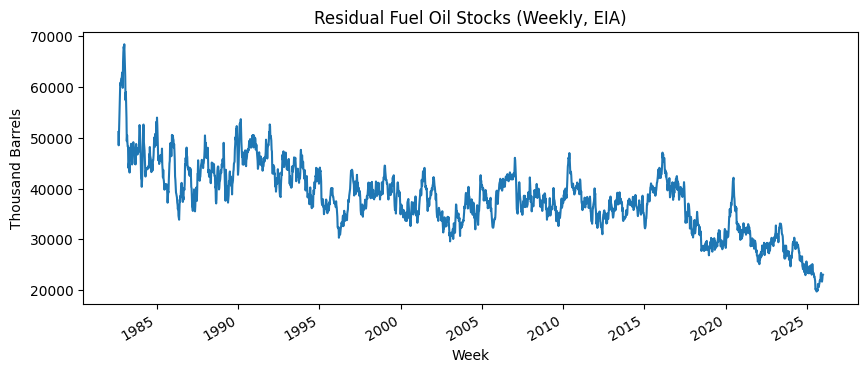

In [15]:
# Residual fuel oil stocks
if "residual_fuel_oil_stocks" in fuel_balance.columns:
    plt.figure(figsize=(10,4))
    fuel_balance["residual_fuel_oil_stocks"].plot()
    plt.title("Residual Fuel Oil Stocks (Weekly, EIA)")
    plt.ylabel("Thousand Barrels")
    plt.xlabel("Week")
    plt.show()

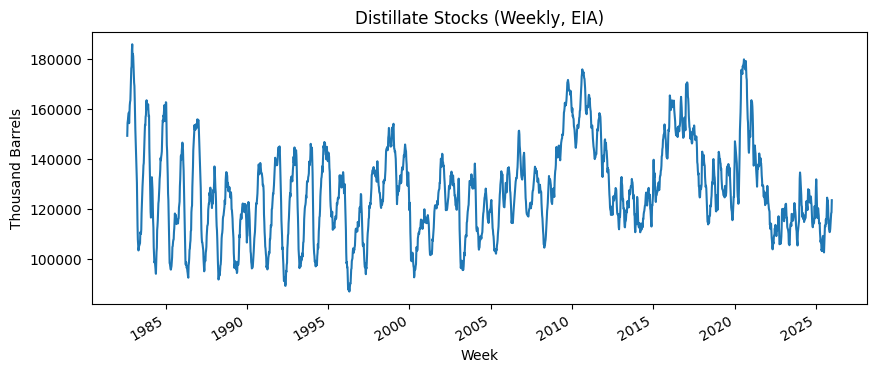

In [16]:
# Distillate stocks
if "distillate_stocks" in fuel_balance.columns:
    plt.figure(figsize=(10,4))
    fuel_balance["distillate_stocks"].plot()
    plt.title("Distillate Stocks (Weekly, EIA)")
    plt.ylabel("Thousand Barrels")
    plt.xlabel("Week")
    plt.show()

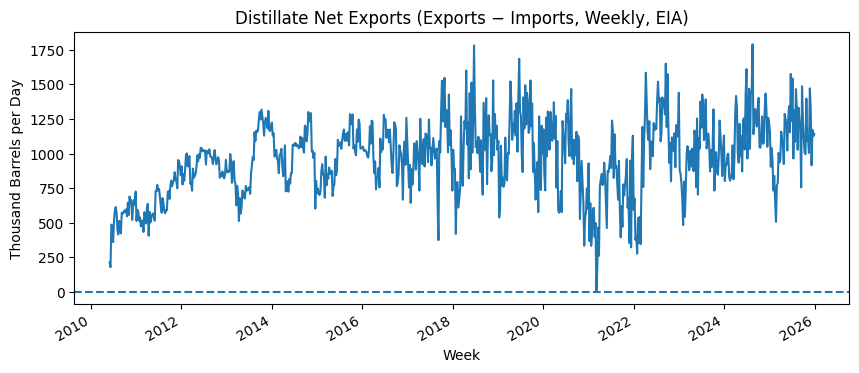

In [17]:
# Distillate net exports
if "distillate_net_exports" in fuel_balance.columns:
    plt.figure(figsize=(10,4))
    fuel_balance["distillate_net_exports"].plot()
    plt.axhline(0, linestyle="--")
    plt.title("Distillate Net Exports (Exports − Imports, Weekly, EIA)")
    plt.ylabel("Thousand Barrels per Day")
    plt.xlabel("Week")
    plt.show()

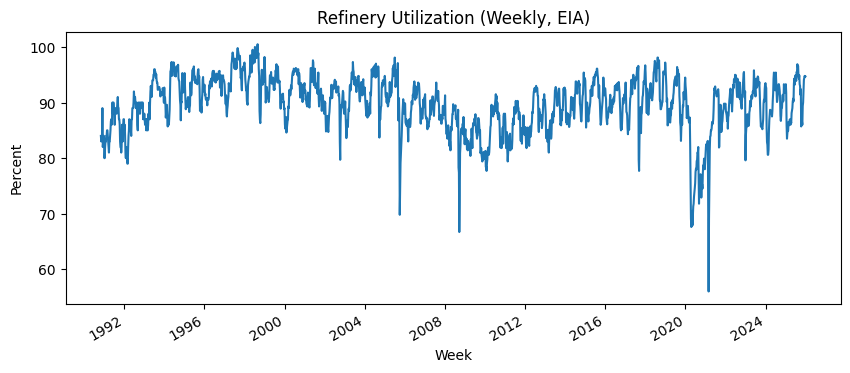

In [18]:
# Refinery utilization
if "refinery_utilization" in fuel_balance.columns:
    plt.figure(figsize=(10,4))
    fuel_balance["refinery_utilization"].plot()
    plt.title("Refinery Utilization (Weekly, EIA)")
    plt.ylabel("Percent")
    plt.xlabel("Week")
    plt.show()

**5) Seasonal & Signal Models (EIA)**

Weekly petroleum markets are seasonal (maintenance cycles, weather, demand patterns).  
We normalize inventories using a 5-year seasonal baseline:

- Seasonal average by ISO week
- Deviation from seasonal norm (tight vs loose)
- Simple classification for decision support

In [19]:
seasonal = fuel_balance.copy()
seasonal["year"] = seasonal.index.year
seasonal["week"] = seasonal.index.isocalendar().week.astype(int)

LATEST_YEAR = seasonal["year"].max()
BASE_YEARS = 5
base = seasonal[seasonal["year"] >= LATEST_YEAR - BASE_YEARS]

def add_seasonal(series_name: str, out_prefix: str):
    if series_name not in seasonal.columns:
        return
    seasonal_avg = base.groupby("week")[series_name].mean().rename(f"{out_prefix}_seasonal_{BASE_YEARS}y_avg")
    seasonal[out_prefix+"_seasonal_avg"] = seasonal["week"].map(seasonal_avg)
    seasonal[out_prefix+"_seasonal_diff"] = seasonal[series_name] - seasonal[out_prefix+"_seasonal_avg"]

add_seasonal("crude_oil_stocks_ex_spr", "crude")
add_seasonal("residual_fuel_oil_stocks", "resid")
add_seasonal("distillate_stocks", "dist")

seasonal.tail()

metric,crude_oil_stocks_ex_spr,distillate_exports,distillate_imports,distillate_product_supplied,distillate_stocks,refinery_utilization,residual_fuel_oil_stocks,resid_stock_change,dist_stock_change,distillate_net_exports,year,week,crude_seasonal_avg,crude_seasonal_diff,resid_seasonal_avg,resid_seasonal_diff,dist_seasonal_avg,dist_seasonal_diff
period,,,,,,,,,,,,,,,,,,
2025-11-28,427503.0,1517.0,190.0,3430.0,114286.0,94.1,22889.0,21.0,2059.0,1327.0,2025,48,438453.166667,-10950.166667,26278.666667,-3389.666667,122619.666667,-8333.666667
2025-12-05,425691.0,1097.0,181.0,4158.0,116788.0,94.5,21685.0,-1204.0,2502.0,916.0,2025,49,440676.666667,-14985.666667,26481.500000,-4796.500000,124447.166667,-7659.166667
2025-12-12,424417.0,1440.0,268.0,3786.0,118500.0,94.8,22135.0,450.0,1712.0,1172.0,2025,50,438502.666667,-14085.666667,26621.500000,-4486.500000,124503.500000,-6003.500000
2025-12-19,424822.0,1307.0,181.0,4156.0,118702.0,94.6,22988.0,853.0,202.0,1126.0,2025,51,436108.333333,-11286.333333,27090.166667,-4102.166667,123750.333333,-5048.333333
2025-12-26,422888.0,1427.0,283.0,3379.0,123679.0,94.7,23045.0,57.0,4977.0,1144.0,2025,52,433586.666667,-10698.666667,26517.000000,-3472.000000,128343.500000,-4664.500000


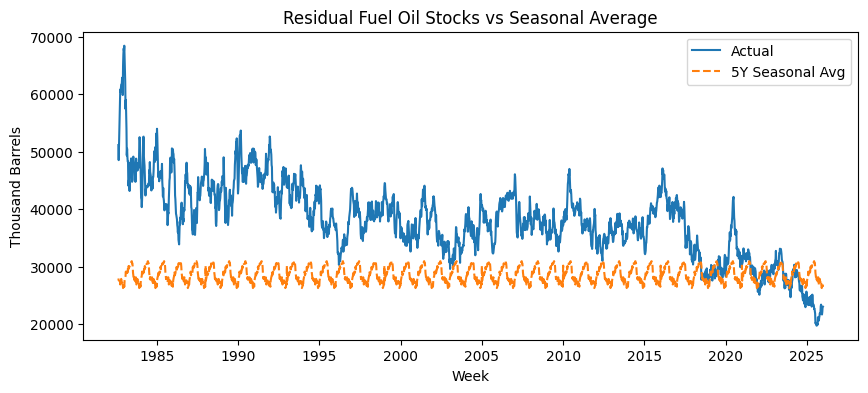

In [20]:
# Residual fuel oil: actual vs seasonal avg
if {"residual_fuel_oil_stocks", "resid_seasonal_avg"}.issubset(seasonal.columns):
    plt.figure(figsize=(10,4))
    plt.plot(seasonal.index, seasonal["residual_fuel_oil_stocks"], label="Actual")
    plt.plot(seasonal.index, seasonal["resid_seasonal_avg"], linestyle="--", label=f"{BASE_YEARS}Y Seasonal Avg")
    plt.title("Residual Fuel Oil Stocks vs Seasonal Average")
    plt.ylabel("Thousand Barrels")
    plt.xlabel("Week")
    plt.legend()
    plt.show()

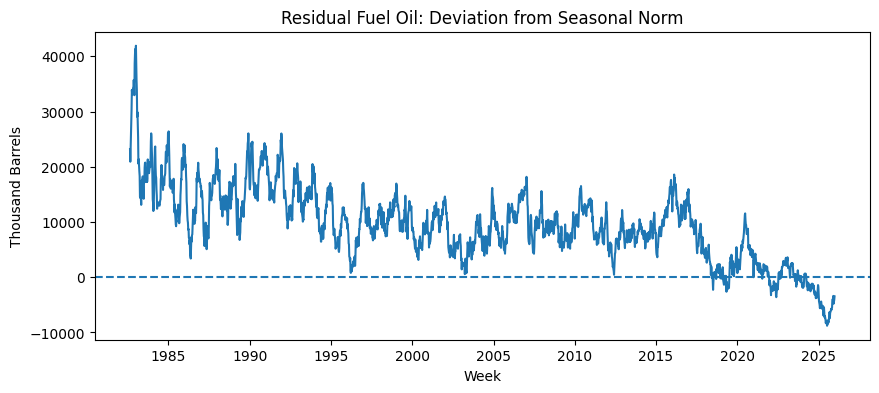

In [21]:
# Residual seasonal deviation
if "resid_seasonal_diff" in seasonal.columns:
    plt.figure(figsize=(10,4))
    plt.plot(seasonal.index, seasonal["resid_seasonal_diff"])
    plt.axhline(0, linestyle="--")
    plt.title("Residual Fuel Oil: Deviation from Seasonal Norm")
    plt.ylabel("Thousand Barrels")
    plt.xlabel("Week")
    plt.show()

**6 Weekly Market Summary (Output)**

We translate indicators into a repeatable weekly summary:
- Balance and deviations vs seasonal norms
- Trade-flow pressure (net exports)
- Utilization (supply-side constraints)
- A directional bias + key risks

In [22]:
latest = seasonal.dropna().iloc[-1]
dt = latest.name.date()

def classify_tightness(diff, threshold=10):
    if pd.isna(diff):
        return "Unknown"
    if diff < -threshold:
        return "Tight"
    if diff > threshold:
        return "Loose"
    return "Near normal"

resid_state = classify_tightness(latest.get("resid_seasonal_diff", np.nan))
dist_state  = classify_tightness(latest.get("dist_seasonal_diff", np.nan))

netexp = latest.get("distillate_net_exports", np.nan)
util = latest.get("refinery_utilization", np.nan)

bias = "Neutral"
if resid_state == "Tight" and dist_state in ["Tight", "Near normal"]:
    bias = "Bullish (supportive cracks / tight balance)"
elif resid_state == "Loose" and dist_state in ["Loose", "Near normal"]:
    bias = "Bearish (oversupply risk)"

note = f"""
## Weekly Fuel Oil / Distillate Market Note — {dt}

### Balance (Seasonal-normalized)
- Residual fuel oil: **{resid_state}** (vs {BASE_YEARS}Y seasonal)
- Distillate: **{dist_state}** (vs {BASE_YEARS}Y seasonal)

### Trade-flow / Arb Proxy
- Distillate net exports (exports − imports): {netexp:.2f} kb/d

### Supply-side driver
- Refinery utilization: {util:.2f}%

### Trading Bias
- **{bias}**

### Key Risks / Watchlist
- Weekly EIA surprises (build/draw volatility) can reprice cracks quickly.
- Export volatility + logistics can shift balances rapidly.
- Refinery outages / maintenance timing can flip the inventory trajectory.
"""
print(note)


## Weekly Fuel Oil / Distillate Market Note — 2025-12-26

### Balance (Seasonal-normalized)
- Residual fuel oil: **Tight** (vs 5Y seasonal)
- Distillate: **Tight** (vs 5Y seasonal)

### Trade-flow / Arb Proxy
- Distillate net exports (exports − imports): 1144.00 kb/d

### Supply-side driver
- Refinery utilization: 94.70%

### Trading Bias
- **Bullish (supportive cracks / tight balance)**

### Key Risks / Watchlist
- Weekly EIA surprises (build/draw volatility) can reprice cracks quickly.
- Export volatility + logistics can shift balances rapidly.
- Refinery outages / maintenance timing can flip the inventory trajectory.



7) Limitations & Extensions

### Limitations
- EIA data is U.S.-centric and does not directly provide hub-level pricing (ARA/Singapore/Fujairah).
- Arbitrage analysis here uses trade flows as a proxy; full arb requires freight + hub differentials.
- World Bank series are annual (macro context) and do not capture weekly price dynamics.

### Extensions (Next Iterations)
- Add monthly World Bank series (or another open benchmark) to connect price momentum to fundamentals.
- Add a hub-based scenario engine (freight shocks, sanctions/compliance costs, route disruptions).
- Forecast inventory deviations (4–8 week horizon) using simple models for scenario planning.